# Predicting 2D diffusion maps from sparse inputs

Generating complex heatmaps with multiple sources are compute intensive algorithms. Often, one must iterate through every pixel in the space, and sum the computed rolled off intensities of every "source" in the space at each pixel location. Typical heatmap algorithms also have a fixed diffusion computation (such as inverse square law) and do not learn actual spatial relationships for intensity / distance. More importantly, there are no off-the-shelf algorithms for modeling diffusion patterns of different IEQ analytes in arbitrary interior spaces. We propose that a Neural Network can learn these patterns and then generate heatmaps from sparse inputs containing measured intensities at known spatial locations. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

253.06064601186551 250.0


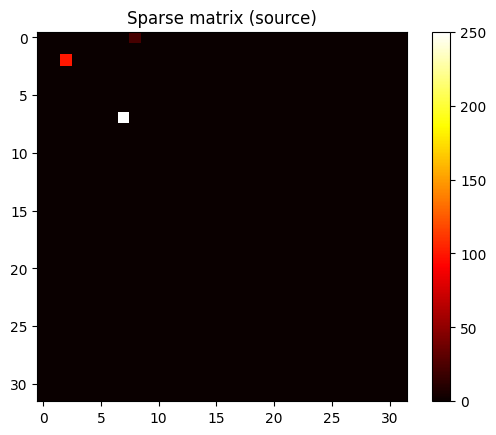

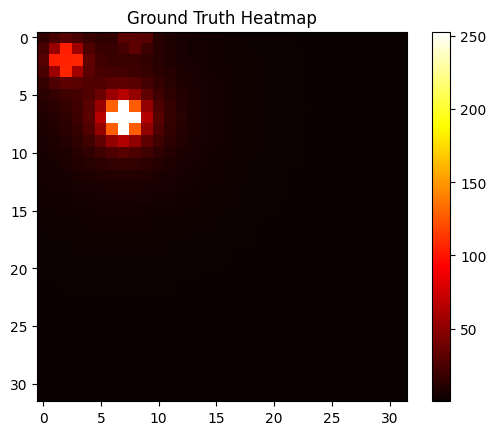

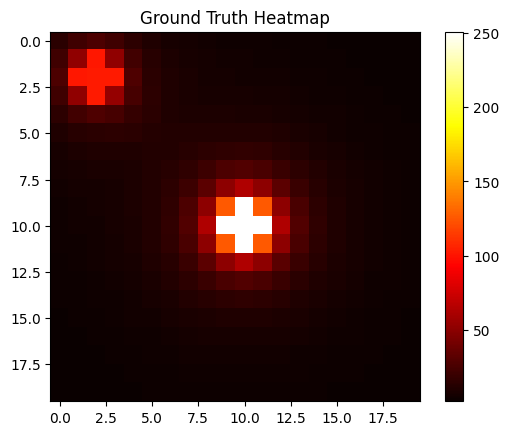

In [5]:
def get_sparse_matrix(m, n, s):
    """In our case, a sparse matrix is a matrix composed mostly of zeros
        with the source intensities representing the non-zero values
        m x n is the output matrix size
        s is a list of "sources" [[intensity_0, x_0, y_0],[intensity_1, x_1, y_1],...]
    """
    matrix = np.zeros((m, n))
    for i in range(s.shape[0]):
        matrix[int(s[i][1])][int(s[i][2])] = s[i][0]

    return matrix

def intensity_from_source(target_x, target_y, source_intensity, source_x, source_y):
    """compute the inverse squared intensity"""
    distance = np.sqrt((source_x - target_x) ** 2 + (source_y - target_y) ** 2)
    if distance == 0:  # Prevent division by zero
        return source_intensity
    return source_intensity / (distance ** 2)

def intensity_matrix(m, n, sources):
    """build a heatmap of m x n size from a list of "sources""""
    matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for source in sources:
                source_intensity, source_x, source_y = source
                matrix[i][j] += intensity_from_source(i, j, source_intensity, source_x, source_y)
    return matrix

253.06064601186551 250.0


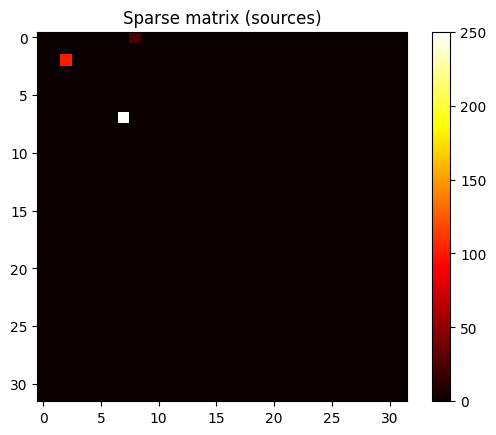

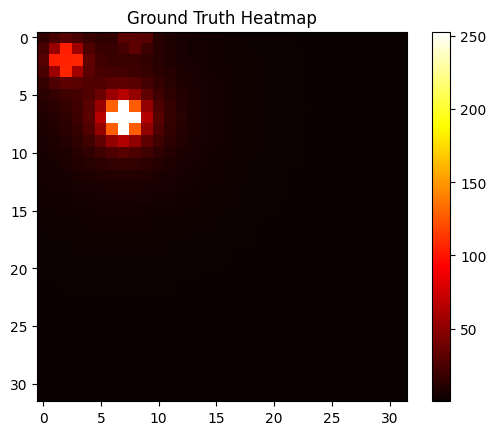

In [14]:
test_sources = np.array([[100, 2, 2], [250, 7, 7], [23, 0, 8]])

test_dim = 32
# Create a ground truth heatmap
ground_truth_heatmap = intensity_matrix(test_dim, test_dim, test_sources)
test_source_sparse = get_sparse_matrix(test_dim, test_dim, test_sources)

print(ground_truth_heatmap.max(), test_source_sparse.max())

# Visualization
plt.imshow(test_source_sparse, cmap='hot', interpolation='nearest')
plt.title("Sparse matrix (sources)")
plt.colorbar()
plt.show()

plt.imshow(ground_truth_heatmap, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

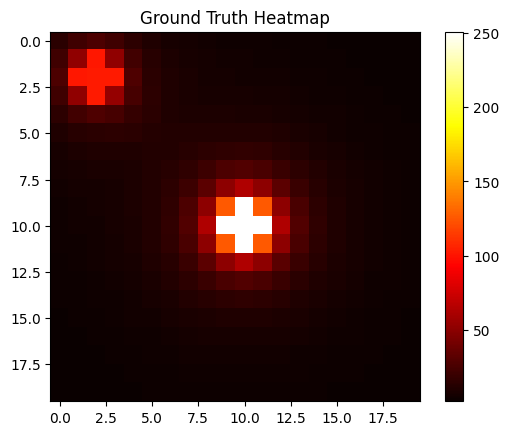

In [15]:
ground_truth_heatmap2 = intensity_matrix(20, 20, [(100, 2, 2), (250, 10, 10), (2, 4, 4)])
plt.imshow(ground_truth_heatmap2, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

Assume we have a fixed number of sensors in a space and we're developing a model based on survey data. Our survey data should be based on fixed snapshots from each sensor (source) at a given point of time, and given those values, we survey a coordinate / X value. We can simulate what an open space heatmap / diffusion looks like with the above code. 

In [16]:
heatmap_w, heatmap_h = 32, 32
num_heatmaps = 3000
random_positions = True

def generate_dataset_sparse(m, n, num_heatmaps=1000, random_pos=False):

    intensity_range = (0,100)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    sparse_matrices = np.zeros((num_heatmaps, m, n))

    for i in range(num_heatmaps):
        
        sources = np.array([[0, 10, 10], [0, 12, 14], [0, 20, 20]])
        
        for k in range(len(sources)):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity

            if random_pos is True:
                x = random.randrange(m)
                y = random.randrange(n)

                sources[k][1] = x
                sources[k][2] = y

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        sparse_matrices[i] = get_sparse_matrix(m, n, sources)

        # print(heatmap_matrices[i].max(), sparse_matrices[i].max())
        
    return sparse_matrices, heatmap_matrices

Xs, Ys = generate_dataset_sparse(heatmap_w, heatmap_h, num_heatmaps, random_positions)

25.01186943620178 25.0


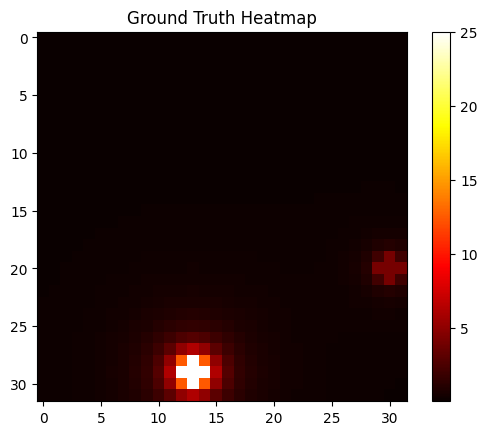

In [17]:
test_index = 3
print(Ys[test_index].max(), Xs[test_index].max())

plt.imshow(Ys[test_index], cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

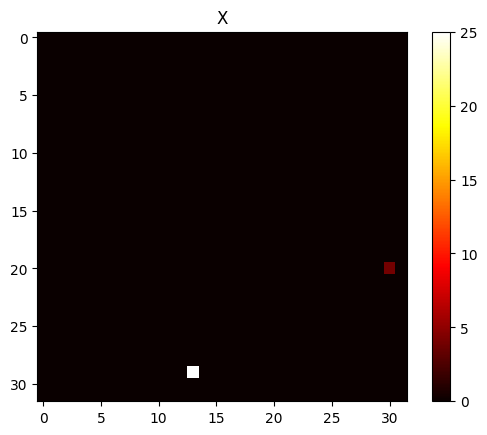

In [18]:
plt.imshow(Xs[test_index], cmap='hot', interpolation='nearest')
plt.title("X")
plt.colorbar()
plt.show()

In [19]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0.2, alpha=0.05):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
        else:
            model.add(Dropout(dropout))
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [20]:
# test the model builder function and use model.summary to verify the shapes we expect from this test
test_model = build_model_leaky(heatmap_w*heatmap_h, [1024, 1024, 2048], n_out=heatmap_w*heatmap_h)

# show the model summary
test_model.summary()

# also, verify the input / output shapes since model.summary only shows outputs
for i, layer in enumerate(test_model.layers):
    print("Layer {0} input shape: {1} output shape:{2}".format(i+1, layer.input_shape[1], layer.output_shape[1]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 2048)             

In [21]:
Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 1024) (2400, 1024)
(600, 1024) (600, 1024)


In [13]:
n_epochs = 100
hidden_layers = [512, 1024, 2048]
batch_size = 64

best_model_name = 'best_linear_dispersion_model.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='max'
)  

# build the model
model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint]
                    verbose=1)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1124081254.py, line 23)

In [ ]:
preds = model.predict(X_test)

In [ ]:
print(preds[20].shape)

In [ ]:
def plot_compare_heatmaps(original, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original heatmap
    im1 = axes[0].imshow(original, cmap='viridis', origin='lower')
    axes[0].set_title("Original Intensity")
    fig.colorbar(im1, ax=axes[0])

    # Plot predicted heatmap
    im2 = axes[1].imshow(predicted, cmap='viridis', origin='lower')
    axes[1].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [ ]:
plt.imshow(preds[20].reshape(heatmap_w, heatmap_h), cmap='hot', interpolation='nearest')
plt.title("Predicted Heatmap")
plt.colorbar()
plt.show()

In [ ]:
def plot_compare_heatmaps(input, original, predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Plot original heatmap
    im0 = axes[0].imshow(input, cmap='viridis', origin='lower')
    axes[0].set_title("Sparse input")
    fig.colorbar(im0, ax=axes[0])

    # Plot original heatmap
    im1 = axes[1].imshow(original, cmap='viridis', origin='lower')
    axes[1].set_title("Original Intensity")
    fig.colorbar(im1, ax=axes[1])

    # Plot predicted heatmap
    im2 = axes[2].imshow(predicted, cmap='viridis', origin='lower')
    axes[2].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_compare_heatmaps(X_test[10].reshape((heatmap_w, heatmap_h)), y_test[10].reshape((heatmap_w, heatmap_h)), preds[10].reshape((heatmap_w,heatmap_h)))

In [ ]:
plot_compare_heatmaps(X_test[20].reshape((heatmap_w, heatmap_h)), y_test[20].reshape((heatmap_w, heatmap_h)), preds[20].reshape((heatmap_w,heatmap_h)))

## Can we input arbitrary sources / intensites in our sparse matrix. 

The previous model learned to approximate the 2D heatmap algorithm from a fixed number of sparse inputs but can we input arbitrary number / intensity of sources into this model and have it predict the heatmap?

# "Dense" Version

Instead of a sparse matrix as input, the network may learn better where the input matrix contains the source x,y,intensity values as features. However, coming up with an embedding solution for *N* number of dense inputs (*N* sources) will be an exercise for the near future. For now, we'll focus on building a dense input with fixed number of sources and determine if using the x,y location as a feature helps learn the spatial relationships better. 

In [ ]:
def generate_dataset_dense(m, n, num_heatmaps=1000, random_pos=False):

    sources = np.zeros((3, 3))

    if random_pos is False:
        sources = np.array([[0, 2, 2], [0, 10, 10], [0, 23, 8]])

    intensity_range = (10,100)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    dense_matrices = np.zeros((num_heatmaps, sources.shape[0], sources.shape[1]))

    # build num_heatmaps
    for i in range(num_heatmaps):
        # randomize the intensities and / or source positions
        for k in range(sources.shape[0]):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity
            
            if random_pos is True:
                # randomize the source position as well
                source_x = random.uniform(0, m)
                source_y = random.uniform(0, n)
                
                sources[k][1] = source_x
                sources[k][2] = source_y

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        dense_matrices[i] = np.copy(sources)
        
    return dense_matrices, heatmap_matrices